### The code aims to modify the analysis of Yenni et al. (2012):
#### - modifies the parameters to paper's description: "r2 integers from 11 to 20"
#### - removes the filter S1 >= 1 & S2 >= 1
#### - does not truncate the values

#### their original code: https://github.com/gmyenni/RareStabilizationSimulation

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# analyN_function.r

In [2]:
def analyN(r1, r2, a1, a12, a21, a2):
    N1 = (r1 - 1 - (a12 / a2) * (r2 - 1)) / (a1 - a21 * a12 / a2)
    N2 = (r2 - 1 - (a21 / a1) * (r1 - 1)) / (a2 - a21 * a12 / a1)
    if np.isinf(N1) or np.isinf(N2) or np.isnan(N1) or np.isnan(N2):
        initialNsp1 = 0
        initialNsp2 = 0
        N = np.zeros((100, 2))
        N[0, :] = [initialNsp1, initialNsp2]   
        for i in range(1, 100):
            N[i, 0] = max((r1 - 1 - a12 * N[i-1, 1]) / a1, 0)
            N[i, 1] = max((r2 - 1 - a21 * N[i-1, 0]) / a2, 0)
        N1 = np.mean(N[:, 0])
        N2 = np.mean(N[:, 1])
    if N1 < 0 and N2 >= 0:
        N1 = 0
        N2 = (r2 - 1) / a2
    elif N2 < 0 and N1 >= 0:
        N2 = 0
        N1 = (r1 - 1) / a1
    return N1, N2

# getNFD.r

In [3]:
def getPCG(r1, r2, a11, a12, a21, a22, N1, N2):
    newN1 = r1 * N1 / (1 + a11 * N1 + a12 * N2)
    newN2 = r2 * N2 / (1 + a22 * N2 + a21 * N1)
    PGR1 = np.log(newN1) - np.log(N1)
    PGR2 = np.log(newN2) - np.log(N2)
    return PGR1, PGR2

def calculate_metrics(l1, l2, a11, a12, a21, a22, N1, N2):
    Coexist = 0 if N1 < 1 else 1
    S1 = l2 / (1 + (a12 / a22) * (l2 - 1))
    S2 = l1 / (1 + (a21 / a11) * (l1 - 1))
    FE1, FE2 = l1 / l2, l2 / l1  # Fitness equivalence
    Asy = S1 - S2  # Asymmetry
    Rare = 0 if N1 == 0 and N2 == 0 else N1 / (N1 + N2)
    # Calculating covariance for SoS
    x = np.array([N1, N2])
    y_sos = np.array([S1, S2])
    cor_matrix_sos = np.cov(x, y_sos)
    cor_sos = cor_matrix_sos[0, 1]  # Extracting the correlation between N and SoS
    Rank = 0 if N1 == 0 and N2 == 0 else (2 if N1 / (N1 + N2) <= 0.25 else 1)
    # Equilibrium points
    E1 = (l1 - 1) / a11
    E2 = (l2 - 1) / a22
    P = (l1 - 1) / a12
    Q = (l2 - 1) / a21
    # Calculate conditions for A, B, C, D
    A = P > E2 and E1 > Q
    B = E2 > P and Q > E1
    C = P > E2 and Q > E1
    D = E2 > P and E1 > Q
    # Call getPCG to calculate PGR1 and PGR2
    PGR1, PGR2 = getPCG(l1, l2, a11, a12, a21, a22, N1, N2)
    return {"FE1": FE1, "S1": S1, "FE2": FE2, "S2": S2, "Rank": Rank, "Coexist": Coexist, "Asy": Asy, "cor_sos": cor_sos, "Rare": Rare, "PGR1": PGR1, "PGR2": PGR2, "A": A, "B": B, "C": C, "D": D}

# annualplant_2spp_det_par.r

In [4]:
def preprocess_data(pars):
    # Defines frequency-dependent parameters
    if pars == 'r_code': # Their R code
         l1_v = np.arange(10, 21, 1)
         l2_v = np.arange(10, 21, 1)
         a11_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3])
         a12_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
         a21_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
         a22_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    elif pars == 'table1': # Reproduce their Table 1
        l1_v = np.arange(15, 21, 1)
        l2_v = np.arange(15, 21, 1)
        a11_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3])
        a12_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
        a21_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
        a22_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    elif pars == 'paper': # They describe in the paper
         l1_v = np.arange(15, 21, 1)
         l2_v = np.arange(11, 21, 1)
         a11_v = np.arange(0.7, 1, 0.1)
         a12_v = np.arange(0.1, 1, 0.1)
         a21_v = np.arange(0.1, 1, 0.1)
         a22_v = np.arange(0.1, 1, 0.1)
    else: # minimal: reduced sets of parameters based on the range of their Table 1
        l1_v = np.array([15, 17, 18, 20])
        l2_v = np.array([15, 17, 18, 20])
        a11_v = np.array([0.1, 1, 3])
        a12_v = np.array([0.1, 0.5, 1])
        a21_v = np.array([0.1, 0.5, 1])
        a22_v = np.array([0.1, 0.5, 1])
    # Generate all combinations of parameters using NumPy's meshgrid
    mesh = np.array(np.meshgrid(l1_v, l2_v, a11_v, a12_v, a21_v, a22_v)).T.reshape(-1, 6)
    return mesh

def Sim(k, mesh_row):
    l1, l2, a11, a12, a21, a22 = mesh_row
    N1, N2 = analyN(l1, l2, a11, a12, a21, a22)
    metrics = calculate_metrics(l1, l2, a11, a12, a21, a22, N1, N2)
    return {**metrics, "N1": N1, "N2": N2, "l1": l1, "l2": l2, "a11": a11, "a12": a12, "a21": a21, "a22": a22}

def postprocess_results(results, outfile):
    column_order = ['l1', 'l2', 'a11', 'a12', 'a21', 'a22', 'N1', 'N2', 'FE1', 'S1', 'FE2', 'S2', 'Rank', 'Coexist', 'Asy', 'cor_sos', 'Rare', 'PGR1', 'PGR2', 'A', 'B', 'C', 'D']
    simul = pd.DataFrame(results, columns=column_order)
    simul.to_csv(outfile, index=False)

# cor_figure.r

In [5]:
def cor_figure(filter):
    dat_det = pd.read_csv("csv/annplant_2spp_det_rare.csv")
    if filter == 'inverted':
        dat_det = dat_det.query('Rank == 2 & & S1 < 1 & S2 < 1').copy()
    elif filter == 'on':
        dat_det = dat_det.query('Rank == 2 & S1 >= 1 & S2 >= 1').copy()
    else: # 'off'
        dat_det = dat_det.query('Rank == 2').copy()
    dat_det.reset_index(drop=True, inplace=True)
#     dat_det = np.trunc(dat_det * 100) / 100.0
    dat_det.sort_values(by=['a22', 'a21', 'a12', 'a11', 'l2', 'l1'], inplace=True)
    dat_det.to_csv("csv/annplant_2spp_det_rare_filtered.csv", index=False)

# figures_det.r

In [6]:
def perform_logistic_regression(dat, analysis_type, print_on=False):
    predictors_map = {
        'SoS': ['S1', 'FE1', 'cor_sos'],
    }    
    predictors = predictors_map[analysis_type]
    X = sm.add_constant(dat[predictors])
    y = dat['Coexist']
    model = sm.GLM(y, X, family=sm.families.Binomial())
    result = model.fit()
    print(result.summary())
    print('\n------------\n')
    coef = result.params
    std_err = result.bse
    z_scores = result.tvalues
    p_values = result.pvalues
    intercept = coef[0]
    coef = coef[1:]
    #extract p-values for all predictor variables
    print('p-values:\n')
    for num_pred in range (0, 4):
        print(result.pvalues[num_pred])
    if print_on:
        result_table = result.summary2().tables[1]
        # Apply maximum precision to coefficient-related statistics
        result_table['Coef.'] = result_table['Coef.']
        result_table['Std.Err.'] = result_table['Std.Err.']
        result_table['z'] = result_table['z'].apply(lambda x: np.format_float_scientific(x, precision=4))
        result_table['P>|z|'] = result_table['P>|z|'].apply(lambda x: np.format_float_scientific(x, precision=4))
        result_table = result_table.round(4)
        print(f"\n{analysis_type} Analysis (statsmodels):")
        print(result_table)
    return intercept, coef, std_err, z_scores, p_values

def calculate_proportions(dat, correlation_type):
    proportions = {}
    for cor_type in [correlation_type]:
        proportions[f'positive_coexistence_{cor_type}'] = len(dat[(dat[cor_type] >= 0) & (dat['Coexist'] == 1)])
        proportions[f'positive_exclusion_{cor_type}'] = len(dat[(dat[cor_type] >= 0) & (dat['Coexist'] == 0)])
        proportions[f'negative_coexistence_{cor_type}'] = len(dat[(dat[cor_type] < 0) & (dat['Coexist'] == 1)])
        proportions[f'negative_exclusion_{cor_type}'] = len(dat[(dat[cor_type] < 0) & (dat['Coexist'] == 0)])
    return proportions

def report_coexistence_analysis(proportions, correlation_type):
    positive_key = f'positive_coexistence_{correlation_type}'
    negative_key = f'negative_coexistence_{correlation_type}'
    neg_confint = proportion_confint(count=proportions[negative_key], nobs=proportions[negative_key] + proportions[f'negative_exclusion_{correlation_type}'], alpha=0.05, method='wilson')
    pos_confint = proportion_confint(count=proportions[positive_key], nobs=proportions[positive_key] + proportions[f'positive_exclusion_{correlation_type}'], alpha=0.05, method='wilson')
    print(f"\nAnalysis on Negative \u03BD for {correlation_type.upper()}:")
    print(f"Proportion of coexistence with \u03BD \u2265 0: {proportions[positive_key] / (proportions[positive_key] + proportions[f'positive_exclusion_{correlation_type}']):.4f} (95% CI: {pos_confint})")
    print(f"Proportion of coexistence with \u03BD < 0: {proportions[negative_key] / (proportions[negative_key] + proportions[f'negative_exclusion_{correlation_type}']):.4f} (95% CI: {neg_confint})")
    
def analyze_coexistence_effect(data):
    original_dat = data.copy()
    models_results = {}
    for correlation_type in ['SoS']:
        analysis_type = f'{correlation_type}'
        correlation_column = 'cor_sos'
        if correlation_column not in data.columns:
            continue
        print(f"\n--- Analysis for {analysis_type} ---")
        intercept, coef, std_err, z_scores, p_values = perform_logistic_regression(data, analysis_type, print_on=True)
        models_results[analysis_type] = {
            'statsmodels': (intercept, coef, std_err, z_scores, p_values),
        }
        proportions = calculate_proportions(data, correlation_column)
        report_coexistence_analysis(proportions, correlation_column)
        table_data = {
            '\u03BD \u2265 0': [proportions[f'positive_coexistence_{correlation_column}'], proportions[f'positive_exclusion_{correlation_column}']],
            '\u03BD < 0': [proportions[f'negative_coexistence_{correlation_column}'], proportions[f'negative_exclusion_{correlation_column}']]
        }
        table_df = pd.DataFrame(table_data, index=['Coexistence', 'Exclusion'])
        print(f"Coexistence and Exclusion based on \u03BD for {analysis_type}:\n", table_df)
        # Proportion of coexistence calculations and confidence intervals
        pos_confint = proportion_confint(count=proportions[f'positive_coexistence_{correlation_column}'], nobs=proportions[f'positive_coexistence_{correlation_column}'] + proportions[f'positive_exclusion_{correlation_column}'], alpha=0.05, method='wilson')
        neg_confint = proportion_confint(count=proportions[f'negative_coexistence_{correlation_column}'], nobs=proportions[f'negative_coexistence_{correlation_column}'] + proportions[f'negative_exclusion_{correlation_column}'], alpha=0.05, method='wilson')
        # Decision making based on confidence intervals
        if neg_confint[1] >= pos_confint[0] and neg_confint[0] <= pos_confint[1]:  # Overlap
            print(f"The confidence intervals overlap for {analysis_type}, indicating they are statistically the same, not supporting the authors' results.")
        elif neg_confint[1] > pos_confint[0]:  # Negative larger than positive
            print(f"Higher coexistence observed with \u03BD < 0 for {analysis_type}, supporting the authors' results.")
        else:  # Negative smaller than positive
            print(f"Higher coexistence observed with \u03BD \u2265 0 for {analysis_type}, not supporting the authors' results.")
    return models_results

In [7]:
def count_abcd(filtered_data):
    # Initialize counters
    count_A_0, count_A_1 = 0, 0
    count_B_0, count_B_1 = 0, 0
    count_C_0, count_C_1 = 0, 0
    count_D_0, count_D_1 = 0, 0
    # Loop over the filtered dataset and apply the conditions for A, B, C, D
    for index, row in filtered_data.iterrows():
        P = (row['l1'] - 1) / row['a12']
        E2 = (row['l2'] - 1) / row['a22']
        Q = (row['l2'] - 1) / row['a21']
        E1 = (row['l1'] - 1) / row['a11']
        if P > E2 and E1 > Q:
            if row['Coexist'] == 0:
                count_A_0 += 1
            else:
                count_A_1 += 1
        elif E2 > P and Q > E1:
            if row['Coexist'] == 0:
                count_B_0 += 1
            else:
                count_B_1 += 1
        elif P > E2 and Q > E1:
            if row['Coexist'] == 0:
                count_C_0 += 1
            else:
                count_C_1 += 1
        elif E2 > P and E1 > Q:
            if row['Coexist'] == 0:
                count_D_0 += 1
            else:
                count_D_1 += 1
    # Calculate totals for A, B, C, D
    count_A_total = count_A_0 + count_A_1
    count_B_total = count_B_0 + count_B_1
    count_C_total = count_C_0 + count_C_1
    count_D_total = count_D_0 + count_D_1
    total_count = count_A_total + count_B_total + count_C_total + count_D_total
    # Calculate proportions
    prop_A = count_A_total / total_count if total_count != 0 else 0
    prop_B = count_B_total / total_count if total_count != 0 else 0
    prop_C = count_C_total / total_count if total_count != 0 else 0
    prop_D = count_D_total / total_count if total_count != 0 else 0
    # Print results
    print(f"A\nCoexist==0: {count_A_0}\nCoexist==1: {count_A_1}\nTotal: {count_A_total}\nProportion: {prop_A:.4f}")
    print(f"\nB\nCoexist==0: {count_B_0}\nCoexist==1: {count_B_1}\nTotal: {count_B_total}\nProportion: {prop_B:.4f}")
    print(f"\nC\nCoexist==0: {count_C_0}\nCoexist==1: {count_C_1}\nTotal: {count_C_total}\nProportion: {prop_C:.4f}")
    print(f"\nD\nCoexist==0: {count_D_0}\nCoexist==1: {count_D_1}\nTotal: {count_D_total}\nProportion: {prop_D:.4f}")

In [8]:
def plot_phase_plane():
    # Parameters for each scenario
    scenarios = {
        "(a) A1: $E_1 > Q$ and $P > E_2$": {'r1': 18, 'r2': 16, 'a11': 0.5, 'a12': 1, 'a21': 1, 'a22': 1},
        "(b) A2: $Q > E_1$ and $E_2 > P$": {'r1': 20, 'r2': 15, 'a11': 2, 'a12': 1, 'a21': 1, 'a22': 0.5},
        "(c) B: $Q > E_1$ and $P > E_2$":  {'r1': 20, 'r2': 15, 'a11': 3, 'a12': 0.5, 'a21': 1, 'a22': 0.5},
        "(d) C: $E_1 > Q$ and $E_2 > P$":  {'r1': 16, 'r2': 18, 'a11': 0.3, 'a12': 1, 'a21': 1, 'a22': 0.5},
    }    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()    
    for i, (title, params) in enumerate(scenarios.items()):
        ax = axes[i]
        # Unpack parameters
        r1 = params['r1']
        r2 = params['r2']
        a11 = params['a11']
        a12 = params['a12']
        a21 = params['a21']
        a22 = params['a22']
        # Equilibrium points
        E1 = [(r1 - 1) / a11, 0]
        Q = [(r2 - 1) / a21, 0]
        E2 = [0, (r2 - 1) / a22]
        P = [0, (r1 - 1) / a12]
        E0 = [0, 0]
        # Calculate the intersection point of lines (E1, Q) and (E2, P)
        # Solve the system of linear equations for intersection
        a1 = (P[1] - E1[1]) / (P[0] - E1[0]) if P[0] != E1[0] else float('inf')
        b1 = E1[1] - a1 * E1[0]
        a2 = (E2[1] - Q[1]) / (E2[0] - Q[0]) if E2[0] != Q[0] else float('inf')
        b2 = Q[1] - a2 * Q[0]
        if a1 != a2:  # Ensure lines are not parallel
            E3_x = (b2 - b1) / (a1 - a2) if a1 != float('inf') and a2 != float('inf') else 0
            E3_y = a1 * E3_x + b1 if a1 != float('inf') else a2 * E3_x + b2
            E3 = [E3_x, E3_y]
        else:
            E3 = None
        # Extend axis limits by 10%
        max_N1 = max(E1[0], Q[0])
        max_N2 = max(E2[1], P[1])
        N1 = np.linspace(0, max_N1, 30)
        N2 = np.linspace(0, max_N2, 30)
        N1, N2 = np.meshgrid(N1, N2)
        # Compute the discrete system
        N1_next = r1 * N1 / (1 + a11 * N1 + a12 * N2)
        N2_next = r2 * N2 / (1 + a22 * N2 + a21 * N1)
        # Plot vector field
        ax.quiver(N1, N2, N1_next - N1, N2_next - N2, angles='xy', scale_units='xy', scale=15, color='gray', alpha=1)
        # Plot equilibrium points
        ax.plot(E0[0], E0[1], 'ko', label='E0', markersize=8)
        ax.plot(E1[0], E1[1], 'bo', label='E1', markersize=8)
        ax.plot(Q[0], Q[1], 'ro', label='Q', markersize=8)
        ax.plot(E2[0], E2[1], 'ro', label='E2', markersize=8)
        ax.plot(P[0], P[1], 'bo', label='P', markersize=8)
        # Draw lines between points
        ax.plot([E1[0], P[0]], [E1[1], P[1]], 'b-', lw=2)  # Line between P and E1 (blue)
        ax.plot([Q[0], E2[0]], [Q[1], E2[1]], 'r-', lw=2)  # Line between Q and E2 (red)
        # Plot intersection point E3 if it exists within the plot limits and above the lines
        if E3 is not None and (0 <= E3[0] <= 1.1 * max_N1) and (0 <= E3[1] <= 1.1 * max_N2):
            ax.plot(E3[0], E3[1], 'go', label=r'$E_3$', markersize=8)
            # Annotate E3 near the point
            ax.annotate(f'$E_3$', xy=(E3[0], E3[1]), xytext=(E3[0] + 0.3, E3[1] + 0.3), fontsize=18, color='green')
        # Set labels and title
        ax.set_xlabel(r'$N_1$', fontsize=18)
        ax.set_ylabel(r'$N_2$', fontsize=18)
        # Move title to the left
        ax.set_title(title, fontsize=18, loc='left')
        # Set xticks and yticks with labels for E1, E2, P, Q
        ax.set_xticks([0, E1[0], Q[0]])
        ax.set_xticklabels([r'$E_0$', r'$E_1$', r'$Q$'])
        ax.set_yticks([0, E2[1], P[1]])
        ax.set_yticklabels([r'$E_0$', r'$E_2$', r'$P$'])
        ax.tick_params(axis='both', which='major', labelsize=18)
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('img/phase_plane.png')
    plt.show()

def plot_frequency_pgr():
    # Parameters for each scenario
    scenarios = {
        "(a) A1: $E_1 > Q$ and $P > E_2$": {'r1': 18, 'r2': 16, 'a11': 0.5, 'a12': 1, 'a21': 1, 'a22': 1},
        "(b) A2: $Q > E_1$ and $E_2 > P$": {'r1': 20, 'r2': 15, 'a11': 2, 'a12': 1, 'a21': 1, 'a22': 0.5},
        "(c) B: $Q > E_1$ and $P > E_2$":  {'r1': 20, 'r2': 15, 'a11': 3, 'a12': 0.5, 'a21': 1, 'a22': 0.5},
        "(d) C: $E_1 > Q$ and $E_2 > P$":  {'r1': 16, 'r2': 18, 'a11': 0.3, 'a12': 1, 'a21': 1, 'a22': 0.5},
    }
    # Arbitrary values for N1
    N1_small = 0.1
    N1_large = 100
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, (title, params) in enumerate(scenarios.items()):
        ax = axes[i]
        # Unpack parameters
        r1 = params['r1']
        r2 = params['r2']
        a11 = params['a11']
        a12 = params['a12']
        a21 = params['a21']
        a22 = params['a22']
        # Adjusting frequency based on parameter set
        freqN1_small = N1_small * (r1 / (r1 + r2)) * (a11 / (a11 + a12))
        freqN2_small = 1 - freqN1_small
        freqN1_large = N1_large * (r1 / (r1 + r2)) * (a21 / (a21 + a22))
        freqN2_large = 1 - freqN1_large
        # Linearly spaced values for plotting
        x_values = np.linspace(0, 1, 100)
        # Example curves for N1 and N2 based on the parameter sets
        y_values_N1 = freqN1_small + (freqN1_large - freqN1_small) * x_values
        y_values_N2 = freqN2_small + (freqN2_large - freqN2_small) * x_values
        # Plot N1 and N2 curves
        ax.plot(x_values, y_values_N1, 'b-', label='N1', markersize=8)
        ax.plot(x_values, y_values_N2, 'r-', label='N2', markersize=8)
        # Set x-axis as frequency and y-axis as log(growth rate)
        ax.set_xlabel('Frequency', fontsize=18)
        ax.set_ylabel('log(PGR)', fontsize=18)
        # Set title
        ax.set_title(title, fontsize=18, loc='left')
        ax.tick_params(axis='both', which='major', labelsize=18)
        # Add legend
        ax.legend(fontsize=14)
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('img/frequency_pgr.png')
    plt.show()

Analysis for All Scenarios:

--- Analysis for SoS ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Coexist   No. Observations:                  682
Model:                            GLM   Df Residuals:                      678
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -335.67
Date:                Thu, 12 Sep 2024   Deviance:                       671.33
Time:                        17:09:24   Pearson chi2:                     632.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2424
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

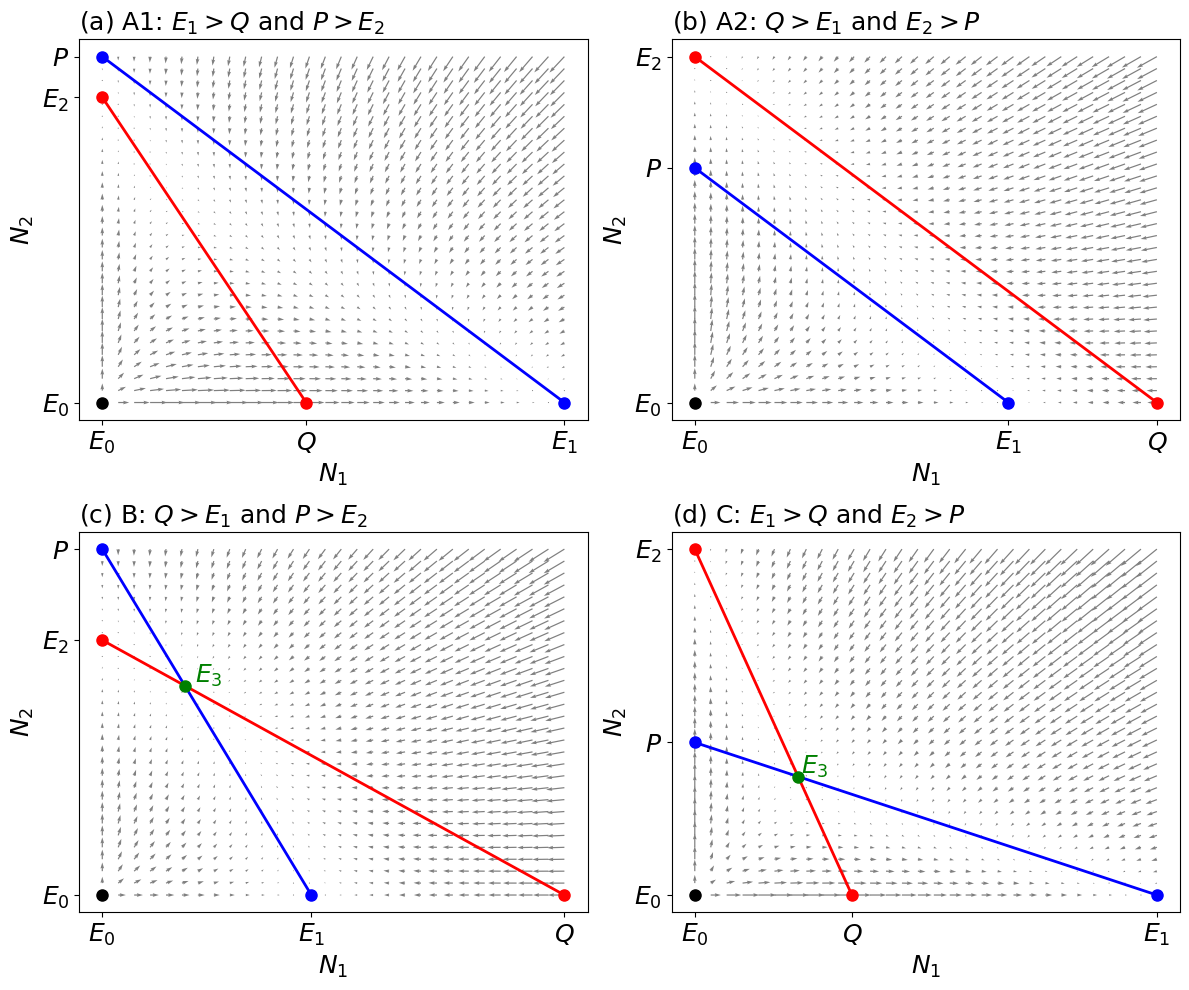



--------------------------------------------------------


A
Coexist==0: 90
Coexist==1: 0
Total: 90
Proportion: 0.1515

B
Coexist==0: 265
Coexist==1: 11
Total: 276
Proportion: 0.4646

C
Coexist==0: 21
Coexist==1: 175
Total: 196
Proportion: 0.3300

D
Coexist==0: 0
Coexist==1: 32
Total: 32
Proportion: 0.0539


In [9]:
def main():
    # Create img and csv directories if they don't exist
    if not os.path.exists('img'):
        os.makedirs('img')
    if not os.path.exists('csv'):
        os.makedirs('csv')
    warnings.filterwarnings("ignore")
    # Specify paths for the output files
    initial_output_file = "csv/annplant_2spp_det_rare.csv"
    filtered_output_file = "csv/annplant_2spp_det_rare_filtered.csv"
    # Generate the parameter mesh
    mesh = preprocess_data('minimal') # options: r_code, table1, paper, or minimal
    # Run the simulation for each parameter set in the mesh
    results = [Sim(k, row) for k, row in enumerate(mesh)]
    # Convert the list of dictionaries into a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(initial_output_file, index=False)
    # Apply filters and generate the filtered data CSV
    cor_figure('off') # options: on, off, or inverted
    # Load the filtered data from CSV into a DataFrame
    filtered_data = pd.read_csv(filtered_output_file)
    # Analysis for all scenarios using the filtered dataset
    print("Analysis for All Scenarios:")
    models_results = analyze_coexistence_effect(filtered_data)  # Pass DataFrame directly
    print("\n\n--------------------------------------------------------\n\n")
#    # Call the function to generate and save the plots
    plot_phase_plane()
#    plot_frequency_pgr()
    print("\n\n--------------------------------------------------------\n\n")
    # Call the function to count and print the occurrences of A, B, C, and D
    count_abcd(filtered_data)

if __name__ == "__main__":
    main()